In [49]:
import sys

from matplotlib.axes import Axes
from matplotlib.figure import Figure
import matplotlib.gridspec as gridspec


sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import matplotlib


from src.loader import is_game_already_saved
from src.gamedb import avg_last_5_or_less_offline
from src.utils import *
from src.gamedb import offline_games_df as offline_df

show_averages = False
heatmap_score_min = 33.0
heatmap_score_max = 45.0
cmap = matplotlib.colormaps['RdYlGn']
gradient = np.linspace(heatmap_score_min, heatmap_score_max, 100)
max_round_scores = [60,6,6,6,12,6,6,18]

matplotlib.rcParams['font.family'] = 'monospace'

all_averages = offline_df.sort_values('game_id').groupby('team_name').tail(5).groupby('team_name').mean(numeric_only=True).round(2)
last_50_offline_games_avg_by_round = offline_df.loc[list(offline_df.groupby('game_id').groups.keys())[-50:]].loc[:,'round_1':'final_score'].mean()
play_counts = offline_df.groupby('team_name')['team_name'].count()


def cmap_color(score):
    y = (score - heatmap_score_min) / (heatmap_score_max - heatmap_score_min)
    return cmap(y)

def trim_label(data):
    return (data[:30] + '…') if len(data) > 30 else data

In [50]:
def create_graph_for_game_id_and_team(game_id, highlighted_team_name, num_teams=0):
    if not is_game_already_saved(game_id):
        print(f"Game {game_id} was not found in the database, run loader first")
        exit(1)

    data = offline_df.loc[(game_id,), :]
    if num_teams == 0: num_teams = data.shape[0]
    q_set = data['question_set'].unique()[0]
    all_scores = data.loc[:, 'round_1':'final_score']
    current_q_set_avg_by_round = offline_df.loc[offline_df.groupby('question_set').groups[q_set]].loc[:,'round_1':'final_score'].mean()

    fig: Figure
    axs: list[Axes]

    fig = plt.figure(figsize=(10, 35), dpi=150)

    gs = gridspec.GridSpec(5, 2, height_ratios=[0.05,1,1,1,1], hspace=0.2)

    heatmap:Axes = plt.subplot(gs[0, :])

    heatmap.tick_params(axis='y', which='both', left=False, labelleft=False)
    for x in gradient:
        heatmap.bar(x, 0.1, color=cmap_color(x))
    heatmap.set_xticks(np.arange(heatmap_score_min, heatmap_score_max + 1, step=1))
    heatmap.margins(x=0, y=0)
    heatmap.set_title("Тепловая карта среднего (за все раунды) счёта команд за последние 5 игр")

    axs = [
       plt.subplot(gs[1, 0]),
       plt.subplot(gs[1, 1]),
       plt.subplot(gs[2, 0]),
       plt.subplot(gs[2, 1]),
       plt.subplot(gs[3, 0]),
       plt.subplot(gs[3, 1]),
       plt.subplot(gs[4, 0]),
       plt.subplot(gs[4, 1]),
    ]

    ytick_labels = list(data.loc[:num_teams]['team_name'].items())

    ax: Axes
    for round_number, ax in enumerate(axs):
        is_total_score = (round_number == 0)
        round_name = f"round_{round_number}" if not is_total_score else 'final_score'

        ax.set_title(f"Раунд {round_number}")

        ax.axvline(all_scores.loc[:][round_name].mean(), color='black', linestyle='dotted', label=f'Среднее в игре {game_id}', alpha=0.6)
        ax.axvline(last_50_offline_games_avg_by_round.loc[round_name], color='black', linestyle='solid',  label='Среднее за последние 50 игр', alpha=0.6)
        ax.axvline(current_q_set_avg_by_round.loc[round_name], color='black', linestyle=(5, (10, 3)), label=f'Среднее по сету #{q_set}', alpha=0.6)


        for place, row in data.loc[:num_teams].iterrows():
            team_name = row['team_name']
            avg = avg_last_5_or_less_offline.loc[team_name]['final_score']
            hatch = '//' if team_name == highlighted_team_name else None
            team_average = all_averages.loc[team_name][round_name]
            team_score = row.loc[round_name]
            avg_color = 'green' if team_score > team_average else 'red'

            bar = ax.barh(place, team_score, hatch=hatch, height=1.0, edgecolor='w', linewidth=1, color=cmap_color(avg))
            
            if show_averages:
                ax.scatter(team_average, place, color=avg_color, edgecolor='black',s=20)

            if is_total_score:
                ax.bar_label(bar)
                ax.set_title("Общий счёт")


        xmax = max_round_scores[round_number]
        xmin = min([0, data.loc[:num_teams][round_name].min()])

        ax.legend(fontsize="8", loc ="lower left")
        ax.set_xlim(xmin=xmin, xmax=xmax)
        
        ax.set_xlabel('Количество очков')
        ax.margins(x=1, y=0)
        ax.invert_yaxis()

        
        ax.set_yticks(np.arange(1, num_teams + 1, step=1))
        if round_number % 2 == 0:
            labels = []
            for item in ytick_labels:
                team_name = item[1]
                game_count = play_counts[team_name]
                stat = f"{game_count} игр{number_to_word_ending_rus(game_count)}"
                team_name_short = f"{trim_label(team_name)}"
                place = f"({item[0]})"
                labels.append(f"{stat:<12} {team_name_short:>32} {place:>4}")
            ax.set_yticklabels(labels)
        else:
            ax.set_ylabel('Место')

    fig.suptitle(f"Анализ игры #{game_id}",y=0.9, fontsize=16)

    plt.subplots_adjust(hspace=0.4)
    plt.show()

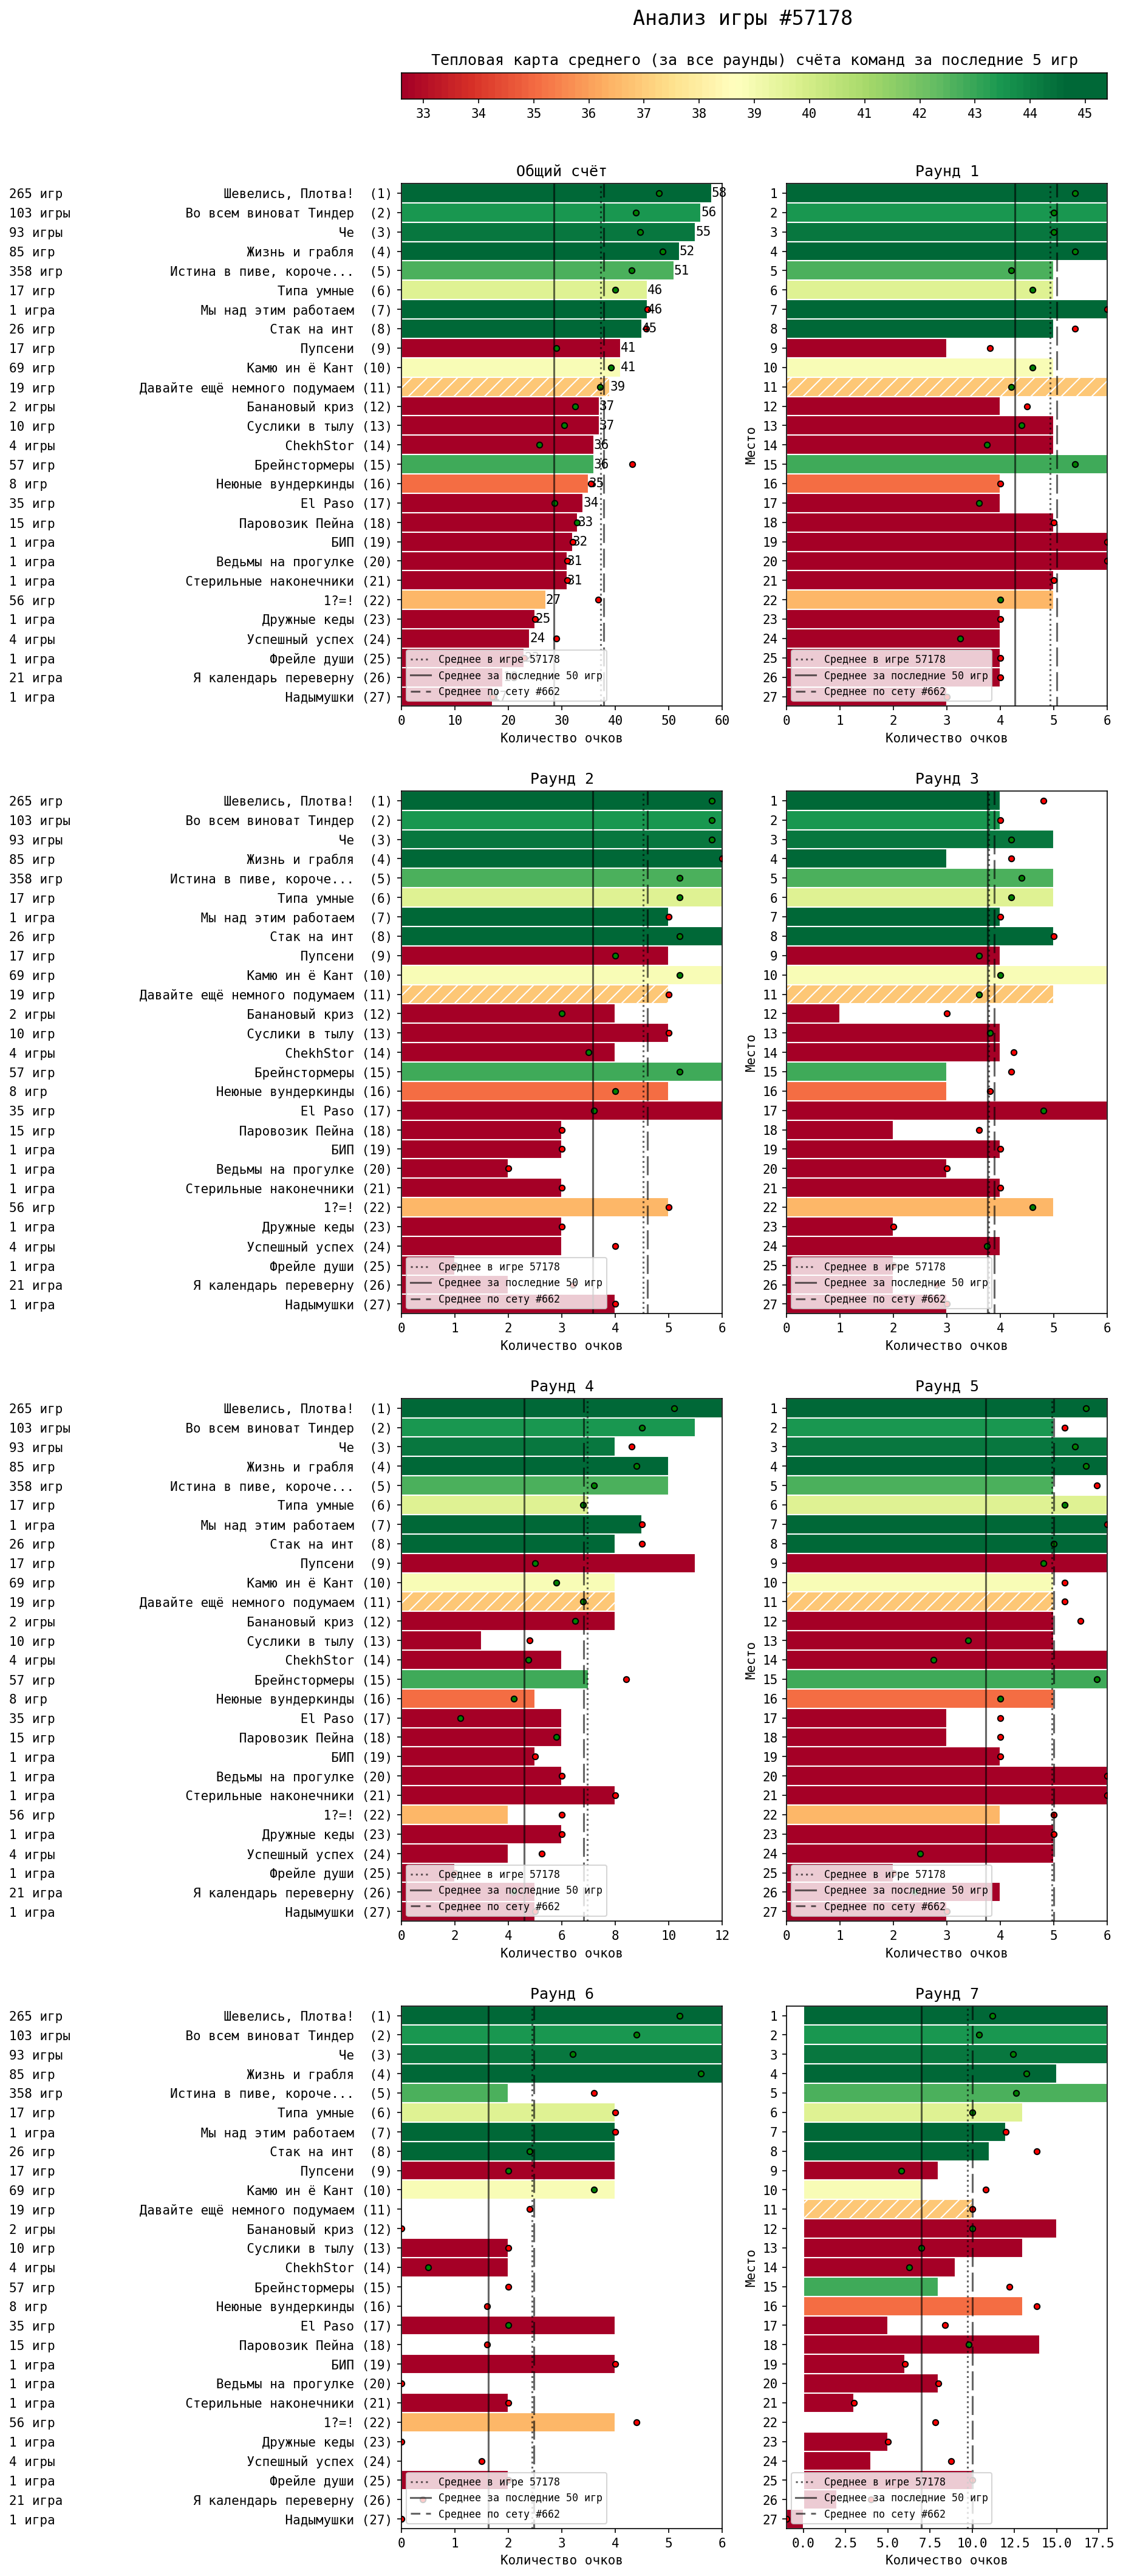

In [51]:
_ = create_graph_for_game_id_and_team(57178, 'Давайте ещё немного подумаем')
